In [2]:
from fslnet.fslnet import FSLNet
import torch

device = "cpu"  # o "cuda"
fslnet = FSLNet.from_pretrained(device=device)


--> Loading FSLNet weights from 'C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\fslnet\checkpoints\fslnet.pth' onto cpu ...
--> FSLNet loaded and set to eval().


In [3]:
from torchvision import datasets, transforms
import numpy as np

transform = transforms.ToTensor()

mnist = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

def get_digit(dataset, digit, n=1000):
    X = []
    for img, label in dataset:
        if label == digit:
            X.append(img.view(-1).numpy())
        if len(X) == n:
            break
    return np.stack(X)


We treat each pixel as a feature and compare its empirical distribution across two sets of images (digits 3 and 8). FSL-Net highlights pixels whose distributions differ between digits, rather than pixels that are discriminative for classification

In [15]:
ref_np = get_digit(mnist, digit=3)
que_np = get_digit(mnist, digit=8)

ref = torch.tensor(ref_np, dtype=torch.float32).to(device)
que = torch.tensor(que_np, dtype=torch.float32).to(device)

print(ref_np.shape)
print(que_np.shape)




(1000, 784)
(1000, 784)


In [16]:
with torch.no_grad():
    soft_predictions, _ = fslnet(ref, que)


In [17]:
P = soft_predictions.squeeze(0).cpu().numpy()
print(P.shape)


(784,)


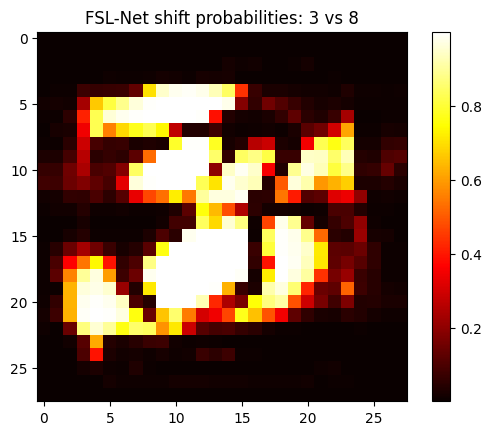

In [18]:
import matplotlib.pyplot as plt

plt.imshow(P.reshape(28, 28), cmap='hot')
plt.colorbar()
plt.title("FSL-Net shift probabilities: 3 vs 8")
plt.show()


The shift probability map shows high responses concentrated along regions where the digit shapes differ, indicating that FSL-Net localizes pixels whose full statistical distributions change between the ‘3’ and ‘8’ digit datasets, while assigning low probabilities to background pixels with stable distributions. We see high probabilities in zones where 3 has trace and 8 doesn't and viceversa. We can see in the middle of the heatmap a trace with practically probability 0, meaning that both 3 and 8 have the same distribution at those points.